# Preproyecto EDPN: Grupo 4 PINNs
## Integrantes:
- Diego Acuña
- Nicolás Herrera
- Paolo Martiniello

Las redes neuronales artificiales (ANNs) han estado a la vanguardia como herramienta matemática para resolver distintos problemas de ingeniería y ciencias. Una de las aplicaciones más prometedoras es en el cálculo de ecuaciones de derivadas parciales (EDPs), en este ámbito el enfoque de las redes neuronales informadas por física (PINNs) ofrecen una alternativa computacionalmente menos costosa. 

El proyecto busca utililzar las PINNs para complementar la falta de datos para entrenar una ANN con conocimiento de las reglas físicas que rigen el sistema.

A continuación se implementará una PINN para resolver un EDO y poteriormente una EDP de alta frecuencia para mostrar también las limitaciones de la herramienta de estudio.

## Parte 1: Resolver una EDO
La ecuación que se modela es la siguiente:
$$
\frac{df(T)}{dt} = Rf(t)(1-f(t))
$$
Donde $f(x)$ representa la tasa de crecimiento de la población a lo largo del tiempo $t$ y el parámetro $R$ proporciona la tasa máxima de crecimiento de la población y afecta fuertemente la forma de la solución. Para especificar completamente la solución de esta ecuación, es necesario imponer una condición de frontera, por ejemplo, en $t = 0$ tal como:
$$
f(0)=0.5
$$
La forma en la que se implementa el conocimiento de la dinámica del problema en el red neuronal es usando esta como función de pérdida para la red:
$$
\frac{df_{NN}(T)}{dt} - Rf_{NN}(t)(1-f_{NN}(t)) = 0
$$

donde $f_{NN}(t)$ es la salida de una red neuronal con una entrada y su derivada se calcula utilizando diferenciación automática.
Para calcular la contribución real de la pérdida proveniente del residuo de la ecuación diferencial, es necesario especificar un conjunto de puntos en el dominio de la ecuación (generalmente conocidos como puntos de colocación) y evaluar una función de pérdida sobre los puntos de colocación elegidos, en este caso se considera el error cuadrático medio (MSE):
$$
\mathcal{L} _{DE}= \frac{1}{M} \sum_{j=1}^M\left( \frac{df_{NN}(t)}{dt}\Big|_{t_{j}} - Rf_{NN}(t_j)(1-f_{NN}(t_j) \right)^2
$$
Sin embargo, una pérdida basada solo en el residuo anterior no garantiza tener una solución única para la ecuación, por lo tanto, se incluye la condición de frontera al cálculo de la pérdida total:
$$
\mathcal{L}_{BC} = (f_{NN}(t_0)-0.5)^2 \hspace{5pt} \text{con } t_0 = 0
$$

Así, la forma final de la función de pérdida será:

$$
\mathcal{L} = \mathcal{L}_{DE} + \mathcal{L}_{BC}
$$

Ahora usamos la herramienta de PyTorch para construir la red neuronal:

In [1]:
from typing import Callable
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchopt
from collections import OrderedDict
from torch.func import functional_call, grad, vmap
import scipy.io
import warnings
import plotly.graph_objects as go
warnings.filterwarnings("ignore")

torch.manual_seed(42)

W0526 21:51:32.167000 13548 torch\distributed\elastic\multiprocessing\redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# Implementación de PINNs para una EDO con Pytorch

class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Arquitectura básica de red neuronal con capas lineales
        
        Args:
            num_inputs (int, opcional): la dimensionalidad del tensor de entrada
            num_layers (int, opcional): el número de capas ocultas
            num_neurons (int, opcional): el número de neuronas para cada capa oculta
            act (nn.Module, opcional): la función de activación no lineal a utilizar para conectar
                las capas lineales
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # capa de entrada
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # capas ocultas con capa lineal y activación
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # capa de salida
        layers.append(nn.Linear(num_neurons, 1))

        # construir la red
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()
    
def make_forward_fn(
    model: nn.Module,
    derivative_order: int = 1,
    ) -> list[Callable]:
        """Crear una función de pase hacia adelante y funciones de gradiente para un modelo dado

        Esta función crea un conjunto de llamadas funcionales del modelo de entrada
    
        Devuelve una lista de versiones v-mapeadas composables del pase hacia adelante
        y de derivadas de orden superior con respecto a las entradas según lo especificado
        por el argumento de entrada `derivative_order`
    
        Args:
            model (nn.Module): el modelo para crear las llamadas funcionales. Puede ser cualquier subclase de
                nn.Module
            derivative_order (int, opcional): Hasta qué orden se devuelven las funciones para calcular la
                derivada del modelo con respecto a las entradas
    
        Returns:
            list[Callable]: Una lista de funciones donde cada elemento corresponde a
                una versión v-mapeada del pase hacia adelante del modelo y sus derivadas. El
                0-ésimo elemento es siempre el pase hacia adelante y, dependiendo del valor del
                argumento `derivative_order`, los siguientes elementos corresponden a
                la función de derivada de i-ésimo orden con respecto a las entradas del modelo. El
                vmap asegura soporte eficiente para entradas en lotes
        """
        def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter] | tuple[torch.nn.Parameter, ...]) -> torch.Tensor:
            if isinstance(params, tuple):
                params_dict = tuple_to_dict_parameters(model, params)
            else:
                params_dict = params
            return functional_call(model, params_dict, (x, ))

        fns = []
        fns.append(f)

        dfunc = f
        for _ in range(derivative_order):
            dfunc = grad(dfunc)
            dfunc_vmap = vmap(dfunc, in_dims=(0, None))
            fns.append(dfunc_vmap)
        return fns

def tuple_to_dict_parameters(
        model: nn.Module, params: tuple[torch.nn.Parameter, ...]
) -> OrderedDict[str, torch.nn.Parameter]:
    """Convertir un conjunto de parámetros almacenados como una tupla en una forma de diccionario

    Esta conversión es necesaria para poder llamar a la API `functional_call` que requiere
    parámetros en forma de diccionario a partir de los resultados de un paso de optimización funcional que 
    devuelve los parámetros como una tupla

    Args:
        model (nn.Module): el modelo para crear las llamadas funcionales. Puede ser cualquier subclase de
            nn.Module
        params (tuple[Parameter, ...]): los parámetros del modelo almacenados como una tupla
    
    Returns:
        Una instancia de OrderedDict con los parámetros almacenados como un diccionario ordenado
    """
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k:v for k,v in zip(keys, values)}))

Ya definido el aproximador universal de funciones se construye la función de pérdida dada por la EDO.

Primero, es necesario elegir un conjunto de puntos de colocación. Dado que se resuelve un problema muy simple, se puede elegir una cuadrícula uniformemente espaciada en el dominio del tiempo: `t = torch.linspace(0, 1, steps=30, requires_grad=True)` o bien muestrear aleatoriamente nuevos puntos de colocación del dominio del tiempo en cada iteración del optimizador.

Para calcular la salida del modelo y su derivada se utiliza la API funcional de PyTorch, que hace que los modelos sean totalmente funcionales al desacoplar los parámetros del propio modelo.

In [3]:
from torch.func import functional_call, grad, vmap

model = LinearNN()

# note que `functional_call` soporta entradas en lotes por defecto
# por lo tanto, no es necesario llamar a vmap en él, como es el caso
# para las llamadas a las derivadas
def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params_dict, (x, ))

# función para calcular gradientes de orden superior con respecto
# a la entrada simplemente componiendo llamadas `grad` y usando nuevamente `vmap` para
# un lote eficiente de la entrada
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

In [4]:
R = 1.0  # tasa de crecimiento máximo de la población que parametriza la ecuación
X_BOUNDARY = 0.0  # coordenada de la condición de frontera
F_BOUNDARY = 0.5  # valor de la condición de frontera

def make_loss_fn(f: Callable, dfdx: Callable) -> Callable:
    """Crear una función de evaluación de pérdida

    La pérdida se calcula como la suma de la pérdida MSE interior (el residuo de la ecuación diferencial)
    y el MSE de la pérdida en la frontera

    Args:
        f (Callable): El pase hacia adelante funcional del modelo utilizado como aproximador universal de funciones. Esta
            es una función con la firma (x, params) donde `x` son los datos de entrada y `params` los parámetros del modelo.
        dfdx (Callable): El cálculo funcional del gradiente del aproximador universal de funciones. Esta
            es una función con la firma (x, params) donde `x` son los datos de entrada y `params` los parámetros del modelo.

    Returns:
        Callable: La función de pérdida con la firma (params, x) donde `x` son los datos de entrada y `params` los parámetros
            del modelo. Nota que una simple llamada a `dloss = functorch.grad(loss_fn)` daría el gradiente
            de la pérdida con respecto a los parámetros del modelo necesarios para los optimizadores.
    """

    def loss_fn(params: torch.Tensor, x: torch.Tensor):
        f_value = f(x, params)
        interior = dfdx(x, params) - R * f_value * (1 - f_value)
        x0 = X_BOUNDARY
        f0 = F_BOUNDARY
        x_boundary = torch.tensor([x0])
        f_boundary = torch.tensor([f0])
        boundary = f(x_boundary, params) - f_boundary

        loss = nn.MSELoss()
        loss_value = loss(interior, torch.zeros_like(interior)) + loss(
            boundary, torch.zeros_like(boundary)
        )

        return loss_value

    return loss_fn

Iteración 0 con pérdida 0.6875214576721191
Iteración 1 con pérdida 0.07539822161197662
Iteración 2 con pérdida 0.061332348734140396
Iteración 3 con pérdida 0.06273966282606125
Iteración 4 con pérdida 0.060336850583553314
Iteración 5 con pérdida 0.06283889710903168
Iteración 6 con pérdida 0.061326973140239716
Iteración 7 con pérdida 0.05547821894288063
Iteración 8 con pérdida 0.056063998490571976
Iteración 9 con pérdida 0.046896230429410934
Iteración 10 con pérdida 0.034501418471336365
Iteración 11 con pérdida 0.023010648787021637
Iteración 12 con pérdida 0.013984388671815395
Iteración 13 con pérdida 0.040047187358140945
Iteración 14 con pérdida 0.01831713318824768
Iteración 15 con pérdida 0.011284725740551949
Iteración 16 con pérdida 0.022073935717344284
Iteración 17 con pérdida 0.029716862365603447
Iteración 18 con pérdida 0.0209547970443964
Iteración 19 con pérdida 0.015735674649477005
Iteración 20 con pérdida 0.013831011950969696
Iteración 21 con pérdida 0.006837353575974703
Iteraci

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


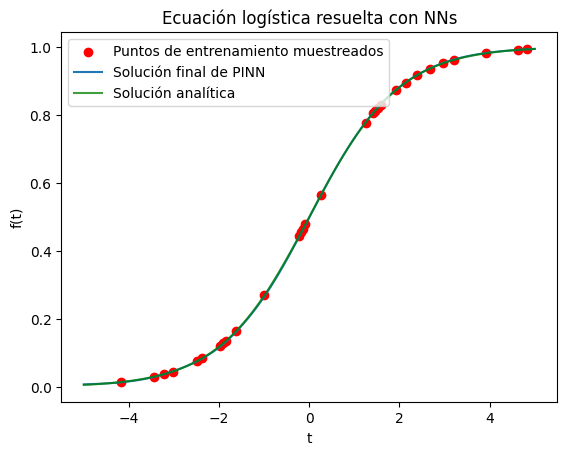

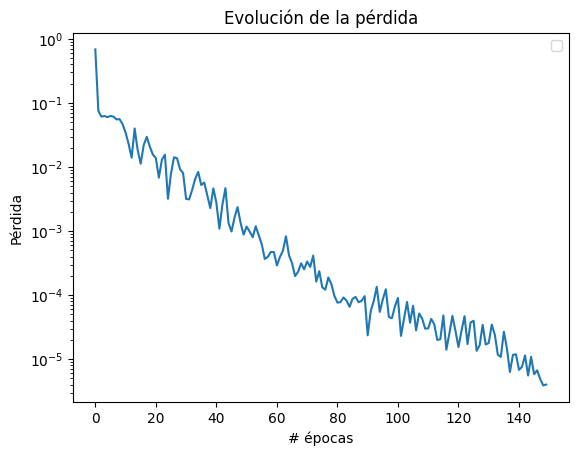

In [5]:
# Fijamos la arquitectura del MLP
num_hidden = 5
dim_hidden = 5
batch_size = 30
num_iter = 150
learning_rate = 0.1
domain = (-5.0, 5.0)

torch.manual_seed(42)

# Configuración
model = LinearNN(num_layers=num_hidden, num_neurons=dim_hidden, num_inputs=1)
funcs = make_forward_fn(model, derivative_order=1)

f = funcs[0]
dfdx = funcs[1]
loss_fn = make_loss_fn(f, dfdx)

# adam como optimizador
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# Parámetros iniciales inicializados aleatoriamente
params = tuple(model.parameters())

# Entrenamos el modelo
loss_evolution = []
for i in range(num_iter):
    # Muestreamos puntos en el dominio aleatoriamente para cada época
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # Calculamos la pérdida con los parámetros actuales
    loss = loss_fn(params, x)

    # Actualizamos los parámetros con el optimizador funcional
    params = optimizer.step(loss, params)

    print(f"Iteración {i} con pérdida {float(loss)}")
    loss_evolution.append(float(loss))

# Graficamos la solución en el dominio dado
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0/F_BOUNDARY - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(x_sample_np, analytical_sol_fn(x_sample_np), color="red", label="Puntos de entrenamiento muestreados")
ax.plot(x_eval_np, f_eval.detach().numpy(), label="Solución final de PINN")
ax.plot(
    x_eval_np,
    analytical_sol_fn(x_eval_np),
    label=f"Solución analítica",
    color="green",
    alpha=0.75,
)
ax.set(title="Ecuación logística resuelta con NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Evolución de la pérdida", xlabel="# épocas", ylabel="Pérdida")
ax.legend()

plt.show()

## Parte 2: Caso EDP donde PINN no converge al aumentar frecuencia
A continuación se muestra la implementación de un código donde se intenta utilizar PINNs para aproximar la solución de una EDP de alta frecuenca. Se puede observar que a medida que aumenta la frecuencia del modelo físico, la PINN tiene mayor pérdida.

Veremos el problema de EDP de Helmholtz

$$ -\Delta u - k_0^2 u = k_0^2 \sin (k_0 x) \sin (k_0 y), \quad \Omega = (0,1)^2 $$
$$ u = 0, \quad ∂ Ω $$

Que tiene solución analítica

$$ u(x, y) =  \sin (k_0 x) \sin (k_0 y)$$

con $k_0 = 2 n \pi$. Para este ejemplo se considera una red neuronal de 3 capas, 100 neuronas por capa, función de activación seno y 3000 iteraciones del optimizador Adam y se estudia el problema para $n \in \{ 1, 3, 5 \}$.

n=1, Iteration 500, Loss: 194.8936004638672
n=1, Iteration 1000, Loss: 170.36097717285156
n=1, Iteration 1500, Loss: 161.8358612060547
n=1, Iteration 2000, Loss: 161.14666748046875
n=1, Iteration 2500, Loss: 158.36891174316406
n=1, Iteration 3000, Loss: 159.39926147460938


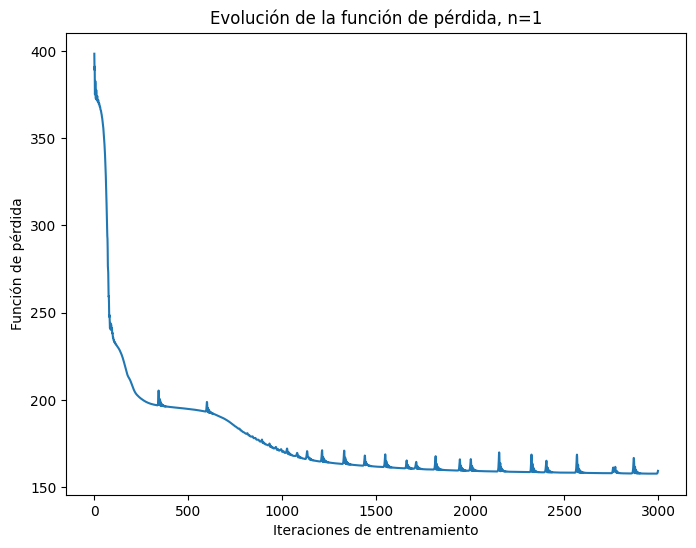

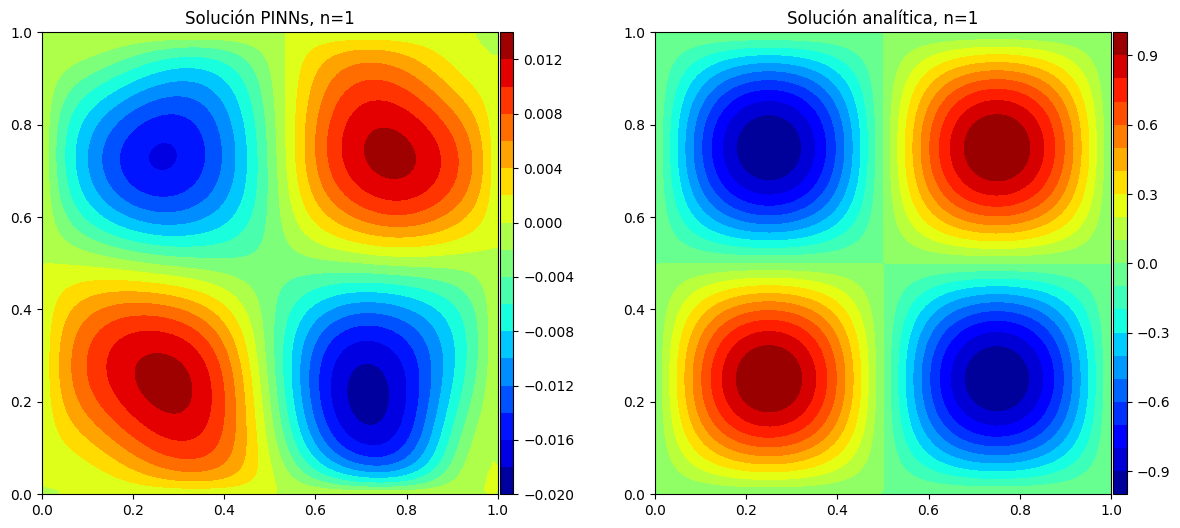

n=3, Iteration 500, Loss: 28502.888671875
n=3, Iteration 1000, Loss: 28044.732421875
n=3, Iteration 1500, Loss: 27080.607421875
n=3, Iteration 2000, Loss: 20507.546875
n=3, Iteration 2500, Loss: 18754.65234375
n=3, Iteration 3000, Loss: 17867.3125


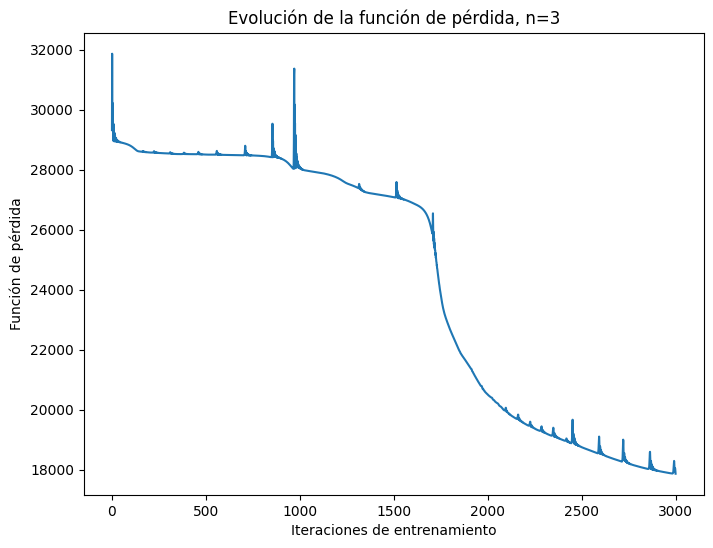

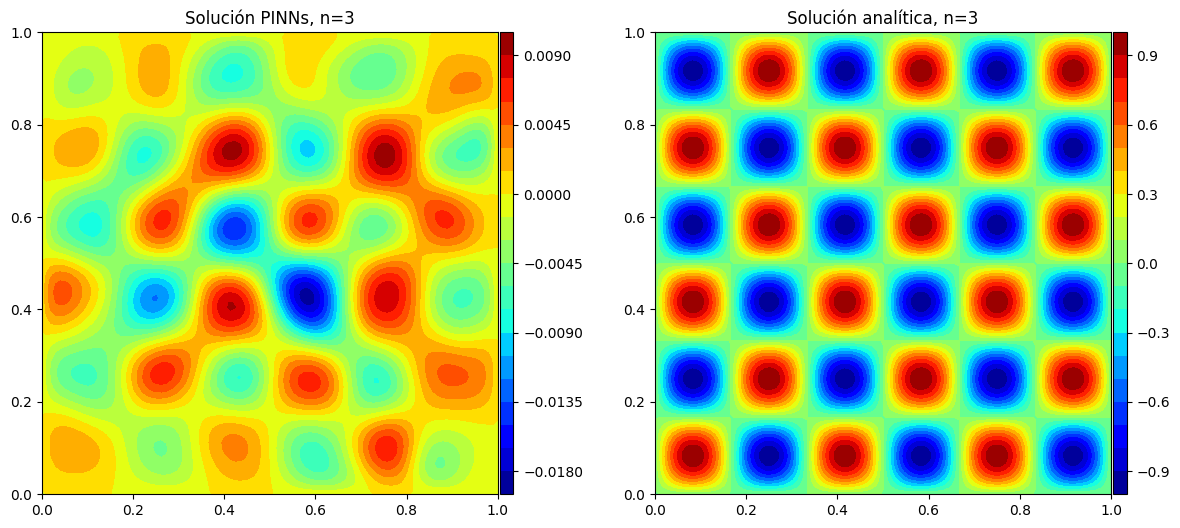

n=5, Iteration 500, Loss: 219428.8125
n=5, Iteration 1000, Loss: 214895.40625
n=5, Iteration 1500, Loss: 208284.546875
n=5, Iteration 2000, Loss: 176690.34375
n=5, Iteration 2500, Loss: 163997.453125
n=5, Iteration 3000, Loss: 153227.71875


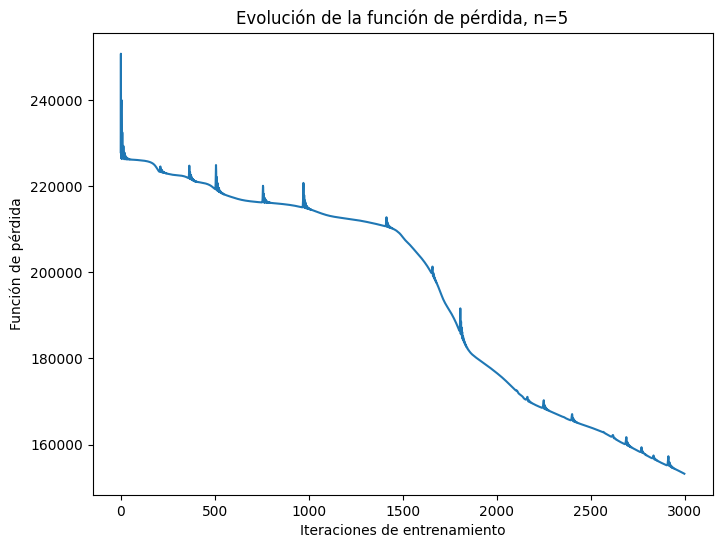

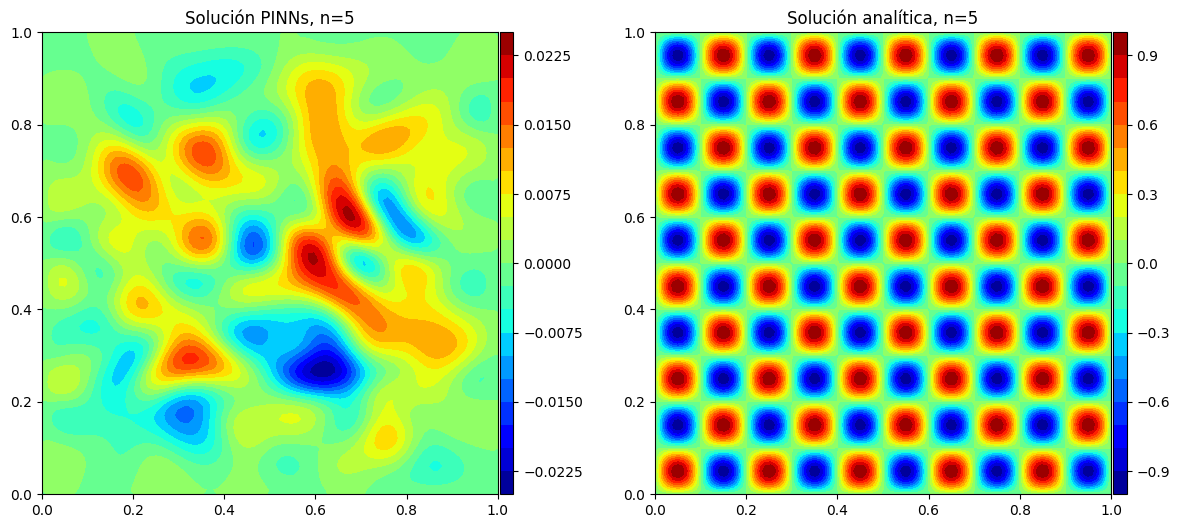

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Dimensión de input
dim_input = 2

# Dimensión de output
dim_output = 1

# Iteraciones del optimizador
iterations = 3000

# Geometría del dominio
geom = [0, 1, 0, 1]

# Condición de frontera
def boundary(x):
    return (x[:, 0] == 0) | (x[:, 0] == 1) | (x[:, 1] == 0) | (x[:, 1] == 1)

# Red neuronal totalmente conectada (FNN)
class FNN(nn.Module):
    def __init__(self, layers, activation):
        super(FNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Transformación para imponer la condición de borde
def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

# Ecuación en derivadas parciales (PDE)
def pde(x, y, net, k0):
    y = net(x)
    dy_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    dy_xx = torch.autograd.grad(dy_x[:, 0], x, grad_outputs=torch.ones_like(dy_x[:, 0]), create_graph=True)[0][:, 0]
    dy_yy = torch.autograd.grad(dy_x[:, 1], x, grad_outputs=torch.ones_like(dy_x[:, 1]), create_graph=True)[0][:, 1]
    f = k0 ** 2 * torch.sin(k0 * x[:, 0:1]) * torch.sin(k0 * x[:, 1:2])
    return f - (-dy_xx - dy_yy - k0 ** 2 * y)

# Generación de datos de entrenamiento
num_domain = 500
x_train = np.random.rand(num_domain, dim_input)
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)

# Parámetros de la red
wide, n_layers, activation = 100, 3, torch.sin
layers = [dim_input] + [wide] * n_layers + [dim_output]

# Valores de n a considerar
n_values = [1, 3, 5]

for n in n_values:
    k0 = 2 * np.pi * n
    net = FNN(layers, activation)
    
    # Optimización
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    loss_history = []
    
    for i in range(iterations):
        optimizer.zero_grad()
        y_pred = transform(x_train, net(x_train))
        loss = pde(x_train, y_pred, net, k0).pow(2).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (i + 1) % 500 == 0:
            print(f"n={n}, Iteration {i + 1}, Loss: {loss.item()}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(iterations), loss_history)
    plt.xlabel("Iteraciones de entrenamiento")
    plt.ylabel("Función de pérdida")
    plt.title(f"Evolución de la función de pérdida, n={n}")
    plt.show()
    
    # Visualización de la solución
    def u_exact(x, y, k0):
        return np.sin(k0 * x) * np.sin(k0 * y)
    
    Nx, Ny = 100, 100
    x, y = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
    
    arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
    X_ = np.hstack(arrays)
    X_ = torch.tensor(X_.T, dtype=torch.float32)
    
    u = transform(X_, net(X_)).detach().numpy()
    
    X, Y = np.meshgrid(x, y)
    
    U_exact = u_exact(X, Y, k0)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    c1 = ax[0].contourf(X, Y, -u.reshape((Nx, Ny)), levels=20, cmap='jet')
    ax[0].set_title(f"Solución PINNs, n={n}")
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c1, cax=cax, orientation='vertical')
    
    c2 = ax[1].contourf(X, Y, U_exact, levels=20, cmap='jet')
    ax[1].set_title(f"Solución analítica, n={n}")
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c2, cax=cax, orientation='vertical')
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()